Подключим нужные библиотеки

In [149]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import re
from scipy.sparse import csc_matrix

from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, precision_score, fbeta_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, normalize
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

Загрузим данные

In [150]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/dataset_bmm.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploration Data Analysis

Изучим данные с помощью функции `describe`

In [151]:
data.describe()

,prompt,canonical_solution,model_response,target
count,6662,6662,6638,6662
unique,6652,6282,6161,2
top,<file_sep><fim_prefix>import pytest\nfrom abst...,\tif err != nil {,},False
freq,2,28,33,4059


Изучим данные с помощью функции `head`

In [152]:
data.head()

,prompt,canonical_solution,model_response,target
0,<file_sep><fim_prefix>// Copyright 2020 The Go...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,False
1,<file_sep><fim_prefix>import re\nimport uuid\n...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",False
2,<file_sep><fim_prefix>package tlsrpt\nimport (...,func (p *parser) wsp() {,//../rfc/8460:374,False
3,"<file_sep><fim_prefix>import { describe, expec...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,False
4,<file_sep><fim_prefix>import type {\n Default...,* Include or exclude stale queries,* Include queries matching this mutation key,False


Создадим отдельный `dataFrame` `data_true`, в котором только целевые признаки со значением `True`

In [153]:
data_true = data[data['target']==True]
data_true.count()

prompt                2603
canonical_solution    2603
model_response        2603
target                2603
dtype: int64

Создадим отдельный `dataFrame` `data_false`, в котором только целевые признаки со значением `False`

In [154]:
data_false=data[data['target']==False]
data_false.count()

prompt                4059
canonical_solution    4059
model_response        4035
target                4059
dtype: int64

Изучим `data_true` с помощью функции `describe`

In [155]:
data_true.describe()

,prompt,canonical_solution,model_response,target
count,2603,2603,2603,2603
unique,2598,2419,2419,1
top,<file_sep><fim_prefix>from abstract_class impo...,return (Criteria) this;,return (Criteria) this;,True
freq,2,10,10,2603


Изучим `data_true` с помощью функции `head`

In [156]:
data_true.head()

,prompt,canonical_solution,model_response,target
6,"<file_sep><fim_prefix>#include ""tachyon/c/zk/p...","tachyon_halo2_bn254_gwc_verifier* verifier,","tachyon_halo2_bn254_gwc_verifier* verifier,",True
9,<file_sep><fim_prefix>// Copyright 2020 The Go...,\tEntryRanger interface{ Range(VisitEntry) },\tEntryRanger interface{ Range(VisitEntry) },True
11,<file_sep><fim_prefix>import type { urlModel }...,\tfield: string;,\tfield: string;,True
16,<file_sep><fim_prefix>import logging\nimport o...,logger.warning(,logger.warning(,True
17,<file_sep><fim_prefix>import pytest\nfrom rest...,"""residual_proba"": RISK_SCENARI...","""residual_proba"": RISK_SCENARI...",True


# Анализ `prompt`

## Проверим гипотезу, что токены находятся в одном и том же месте

In [157]:
data['prompt'][0]

'<file_sep><fim_prefix>// Copyright 2020 The Go Authors. All rights reserved.\n// Use of this source code is governed by a BSD-style\n// license that can be found in the LICENSE file.\npackage order\nimport (\n\t"google.golang.org/protobuf/reflect/protoreflect"\n)\n// FieldOrder specifies the ordering to visit message fields.\n// It is a function that reports whether x is ordered before y.\ntype FieldOrder func(x, y protoreflect.FieldDescriptor) bool\nvar (\n\t// AnyFieldOrder specifies no specific field ordering.\n\tAnyFieldOrder FieldOrder = nil\n\t// LegacyFieldOrder sorts fields in the same ordering as emitted by\n\t// wire serialization in the github.com/golang/protobuf implementation.\n\tLegacyFieldOrder FieldOrder = func(x, y protoreflect.FieldDescriptor) bool {\n\t\tox, oy := x.ContainingOneof(), y.ContainingOneof()\n\t\tinOneof := func(od protoreflect.OneofDescriptor) bool {\n\t\t\treturn od!= nil &&!od.IsSynthetic()\n\t\t}\n\t\t// Extension fields sort before non-extension fi

In [158]:
data['prompt'].apply(lambda x: bool(re.match(r"<file_sep><fim_prefix>.*<fim_suffix><fim_middle>", x, re.DOTALL))).sum() == len(data)

True

In [159]:
data['prompt'].apply(lambda x: x.count("<fim_prefix>")).sum()

6662

In [160]:
data['prompt'].apply(lambda x: x.count("<fim_suffix>")).sum()

6662

Все строки соответствуют одному шаблону.

Попробуем удалить токены в начале и конце элементов столбца `prompt`

In [161]:
data['prompt'] =  list(map(lambda x: x[22:], data['prompt']))
data['prompt'] =  list(map(lambda x: x[:-24], data['prompt']))

In [162]:
data

,prompt,canonical_solution,model_response,target
0,// Copyright 2020 The Go Authors. All rights r...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,False
1,import re\nimport uuid\nimport orjson\nimport ...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",False
2,"package tlsrpt\nimport (\n\t""fmt""\n\t""net/url""...",func (p *parser) wsp() {,//../rfc/8460:374,False
3,"import { describe, expect, test } from '@jest/...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,False
4,"import type {\n DefaultError,\n Enabled,\n ...",* Include or exclude stale queries,* Include queries matching this mutation key,False
...,...,...,...,...
6657,"import { describe, expectTypeOf } from 'vitest...","queryKey: ['key'],","queryKey: ['key'],",True
6658,import moment from'moment';\nimport type { Mom...,dateRangeType: DateRangeType;,dateRangeType: DateRangeType;,True
6659,"package dkim\nimport (\n\t""encoding/base64""\n\...","func (p *parser) xalgorithm() (string, string) {",//../rfc/6376:658,False
6660,package com.tencent.supersonic.headless.chat.k...,String line;,String line = br.readLine();,False


Добавим столбец, в котором будут подсчитано количество слов в столбце `prompt`

In [163]:
data['promptWordCount'] = data['prompt'].str.count(' ') + 1
data

,prompt,canonical_solution,model_response,target,promptWordCount
0,// Copyright 2020 The Go Authors. All rights r...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,False,293
1,import re\nimport uuid\nimport orjson\nimport ...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",False,970
2,"package tlsrpt\nimport (\n\t""fmt""\n\t""net/url""...",func (p *parser) wsp() {,//../rfc/8460:374,False,503
3,"import { describe, expect, test } from '@jest/...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,False,348
4,"import type {\n DefaultError,\n Enabled,\n ...",* Include or exclude stale queries,* Include queries matching this mutation key,False,114
...,...,...,...,...,...
6657,"import { describe, expectTypeOf } from 'vitest...","queryKey: ['key'],","queryKey: ['key'],",True,210
6658,import moment from'moment';\nimport type { Mom...,dateRangeType: DateRangeType;,dateRangeType: DateRangeType;,True,2483
6659,"package dkim\nimport (\n\t""encoding/base64""\n\...","func (p *parser) xalgorithm() (string, string) {",//../rfc/6376:658,False,322
6660,package com.tencent.supersonic.headless.chat.k...,String line;,String line = br.readLine();,False,349


Построим диаграмму, которая демонстрирует как связано количество слов в столбце `prompt` и верную ли подсказку выдала модель.

<Axes: xlabel='None', ylabel='promptWordCount'>

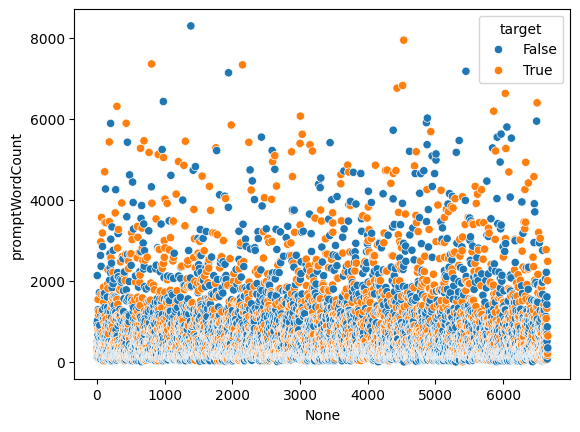

In [164]:
sns.scatterplot(data=data, x=data.index , y=data['promptWordCount'], hue='target')

Вывод: нет корреляции между количеством слов в `prompt` и целевого признака

In [165]:
data.describe(include='all')

,prompt,canonical_solution,model_response,target,promptWordCount
count,6662,6662,6638,6662,6662.000000
unique,6652,6282,6161,2,NaN
top,import pytest\nfrom abstract_class import Ship...,\tif err != nil {,},False,NaN
freq,2,28,33,4059,NaN
mean,NaN,NaN,NaN,NaN,836.639748
std,NaN,NaN,NaN,NaN,964.326102
min,NaN,NaN,NaN,NaN,3.000000
25%,NaN,NaN,NaN,NaN,205.250000
50%,NaN,NaN,NaN,NaN,502.500000
75%,NaN,NaN,NaN,NaN,1082.750000


#BaseLine

## Константная модель 0

In [166]:
def get_scores(y_true, y_pred) -> pd.Series:
    return pd.Series(np.array([accuracy_score(y_true, y_pred),
                     recall_score(y_true, y_pred),
                     f1_score(y_true, y_pred),
                     precision_score(y_true, y_pred),
                     fbeta_score(y_true, y_pred, beta=1.25),
                     roc_auc_score(y_true, y_pred)]),
                     index=['Accuracy', 'Recall', 'F1', 'Precision', 'F_beta', 'ROC_AUC'])

Добавим решение модели, которая утверждает, что модель всегда не угадывает.

In [167]:
data['predConst0'] = 0
data.head()

,prompt,canonical_solution,model_response,target,promptWordCount,predConst0
0,// Copyright 2020 The Go Authors. All rights r...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,False,293,0
1,import re\nimport uuid\nimport orjson\nimport ...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",False,970,0
2,"package tlsrpt\nimport (\n\t""fmt""\n\t""net/url""...",func (p *parser) wsp() {,//../rfc/8460:374,False,503,0
3,"import { describe, expect, test } from '@jest/...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,False,348,0
4,"import type {\n DefaultError,\n Enabled,\n ...",* Include or exclude stale queries,* Include queries matching this mutation key,False,114,0


Исследуем качество модели

In [168]:
get_scores(data['target'], data['predConst0'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy     0.609276
Recall       0.000000
F1           0.000000
Precision    0.000000
F_beta       0.000000
ROC_AUC      0.500000
dtype: float64

## Константная модель 1

Добавим решение модели, которая утверждает, что модель всегда угадывает.

In [169]:
data['predConst1'] = 1
data.head()

,prompt,canonical_solution,model_response,target,promptWordCount,predConst0,predConst1
0,// Copyright 2020 The Go Authors. All rights r...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,False,293,0,1
1,import re\nimport uuid\nimport orjson\nimport ...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",False,970,0,1
2,"package tlsrpt\nimport (\n\t""fmt""\n\t""net/url""...",func (p *parser) wsp() {,//../rfc/8460:374,False,503,0,1
3,"import { describe, expect, test } from '@jest/...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,False,348,0,1
4,"import type {\n DefaultError,\n Enabled,\n ...",* Include or exclude stale queries,* Include queries matching this mutation key,False,114,0,1


Исследуем качество модели

In [170]:
get_scores(data['target'], data['predConst1'])

Accuracy     0.390724
Recall       1.000000
F1           0.561900
Precision    0.390724
F_beta       0.621686
ROC_AUC      0.500000
dtype: float64

## Рандомная модель

In [171]:
random.seed(42)
data['predRandom'] = np.random.choice([True, False], size = len(data['prompt']))
data['predRandom'].astype(int)
data.head()

,prompt,canonical_solution,model_response,target,promptWordCount,predConst0,predConst1,predRandom
0,// Copyright 2020 The Go Authors. All rights r...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,False,293,0,1,False
1,import re\nimport uuid\nimport orjson\nimport ...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",False,970,0,1,False
2,"package tlsrpt\nimport (\n\t""fmt""\n\t""net/url""...",func (p *parser) wsp() {,//../rfc/8460:374,False,503,0,1,False
3,"import { describe, expect, test } from '@jest/...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,False,348,0,1,True
4,"import type {\n DefaultError,\n Enabled,\n ...",* Include or exclude stale queries,* Include queries matching this mutation key,False,114,0,1,False


In [172]:
get_scores(data['target'], data['predRandom'])

Accuracy     0.500600
Recall       0.499040
F1           0.438481
Precision    0.391030
F_beta       0.450481
ROC_AUC      0.500320
dtype: float64

# BaseLine логистическая регрессия

## TF-IDF

In [173]:
def extract_last_n_words(text, n):
  words = text.split()# Разбиваем текст на слова
  if len(words) <= n:
    return text
  else:
    last_n_words = ' '.join(words[-n:])  # Выбираем последние n слов и объединяем их обратно в строку
    return last_n_words

In [174]:
%%time
tfidf_vectorizer = TfidfVectorizer()

# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(data['prompt'])

tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]
tfidf_matrix

CPU times: user 3.43 s, sys: 2.86 s, total: 6.29 s
Wall time: 6.28 s


<6662x46864 sparse matrix of type '<class 'numpy.float64'>'
	with 897545 stored elements in Compressed Sparse Row format>

In [175]:
%%time
tfidf_vectorizer = TfidfVectorizer()

# Применение TF-IDF к текстовым данным
tfidf_matrix_model = tfidf_vectorizer.fit_transform(data['model_response'].astype(str))

tfidf_matrix_model = normalize(tfidf_matrix_model, norm='l2', axis=1)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores_model = tfidf_matrix_model.toarray()[0]
tfidf_matrix_model

CPU times: user 100 ms, sys: 487 ms, total: 588 ms
Wall time: 505 ms


<6662x7742 sparse matrix of type '<class 'numpy.float64'>'
	with 24609 stored elements in Compressed Sparse Row format>

In [176]:
X = csc_matrix(np.concatenate((tfidf_matrix.toarray(), tfidf_matrix_model.toarray()), axis=1))
X

<6662x54606 sparse matrix of type '<class 'numpy.float64'>'
	with 922154 stored elements in Compressed Sparse Column format>

## Логистическая регрессия

In [177]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, data['target'].astype(int),
                                                        test_size=0.20, random_state=42, )

In [179]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [180]:
y_test_pred = logreg.predict(X_test)

In [181]:
get_scores(y_test, y_test_pred)

Accuracy     0.652663
Recall       0.347664
F1           0.445509
Precision    0.620000
F_beta       0.419587
ROC_AUC      0.602403
dtype: float64

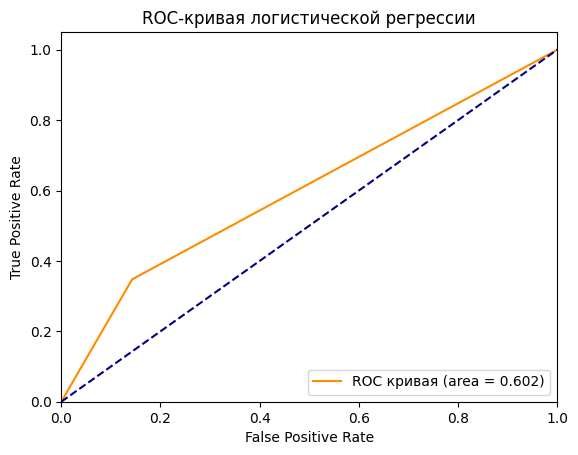

In [182]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_test_pred)
# строим график
plt.plot(fpr, tpr, color='darkorange', label='ROC кривая (area = %0.3f)' % (auc(fpr, tpr)) ) # построение roc-кривой
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # построение идеальной кривой
plt.xlim([0.0, 1.0]) # ограничение по оси x
plt.ylim([0.0, 1.05]) # ограничение по оси y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая логистической регрессии')
plt.legend(loc="lower right") # расположение легенды справа внизу
plt.show()

## Random forest

In [183]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report

In [184]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [185]:
y_test_pred_rf = rf.predict(X_test)

In [186]:
get_scores(y_test, y_test_pred_rf)

Accuracy     0.627157
Recall       0.347664
F1           0.428078
Precision    0.556886
F_beta       0.407394
ROC_AUC      0.581100
dtype: float64

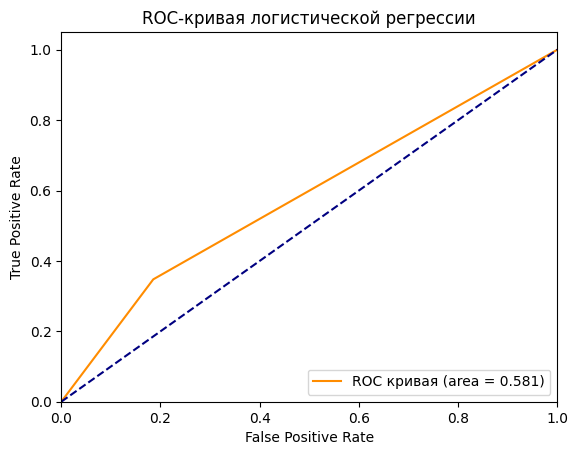

In [187]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_test_pred_rf)
# строим график
plt.plot(fpr, tpr, color='darkorange', label='ROC кривая (area = %0.3f)' % (auc(fpr, tpr)) ) # построение roc-кривой
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # построение идеальной кривой
plt.xlim([0.0, 1.0]) # ограничение по оси x
plt.ylim([0.0, 1.05]) # ограничение по оси y
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая логистической регрессии')
plt.legend(loc="lower right") # расположение легенды справа внизу
plt.show()

## Сокращаем размерность TF-IDF и тестим последние модели

In [188]:
%%time
pca_3d = TruncatedSVD(n_components=3)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(
    tfidf_matrix))

CPU times: user 464 ms, sys: 85.2 ms, total: 549 ms
Wall time: 562 ms


In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, data['target'].astype(int),
                                                        test_size=0.20, random_state=42)

In [190]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [191]:
y_test_pred = logreg.predict(X_test)

In [192]:
get_scores(y_test, y_test_pred)

Accuracy     0.652663
Recall       0.347664
F1           0.445509
Precision    0.620000
F_beta       0.419587
ROC_AUC      0.602403
dtype: float64

In [193]:
y_test_proba_logred_0 = pd.DataFrame( logreg.predict_proba(X)).iloc [:, 0]
y_test_predict_proba_b_60 = pd.DataFrame( logreg.predict_proba(X)).iloc [:, 0]
y_test_predict_proba_b_60.loc[ y_test_proba_logred_0 > -1] = 1
y_test_predict_proba_b_60.loc[ y_test_proba_logred_0 > 0.6] = 0

In [194]:
get_scores(data['target'], y_test_predict_proba_b_60)

Accuracy     0.835785
Recall       0.832885
F1           0.798527
Precision    0.766891
F_beta       0.805824
ROC_AUC      0.835265
dtype: float64

In [195]:
y_test_predict_proba_b_61 = pd.DataFrame( logreg.predict_proba(X)).iloc [:, 0]
y_test_predict_proba_b_61.loc[ y_test_proba_logred_0 > -1] = 1
y_test_predict_proba_b_61.loc[ y_test_proba_logred_0 > 0.61] = 0
get_scores(data['target'], y_test_predict_proba_b_61)

Accuracy     0.834284
Recall       0.848636
F1           0.800072
Precision    0.756766
F_beta       0.810251
ROC_AUC      0.836858
dtype: float64

<font size = 5>САМОЕ ЛУЧШЕЕ РЕШЕНИЕ... БЬЕТ ПО ВСЕМ МЕТРИКАМ ВСЕ ПРЕДЫДУЩИЕ(ОНИ ИДУТ ДАЛЬШЕ...) РЕШЕНИЯ

## peepplane, cross-validation

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, SVR
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import Normalizer
dataProssesed = pd.read_csv('/content/drive/MyDrive/processed_prompt_data.csv')

In [196]:
dataProssesed.head()

,processed_prompt
0,copyright 2020 go author right reserved use so...
1,import import uuid import orjson import stream...
2,package tlsrpt import fmt string extension add...
3,import describe expect test const require cons...
4,import type defaulterror enabled fetchstatus m...


In [65]:
data['target'] = data['target'].astype(int).astype('category')
prikol_data = pd.concat((data['target'], dataProssesed), axis=1)
prikol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6662 entries, 0 to 6661
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   target            6662 non-null   category
 1   processed_prompt  6662 non-null   object  
dtypes: category(1), object(1)
memory usage: 58.8+ KB


In [66]:
%%time

def optimize_pipeline(df_features, target, param_grid, modelSignature, beta=1.25):

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(df_features,
                                                        target,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=target)
    # Стратифицированное разделение данных на обучающую и тестовую выборки гарантирует,
    # что в каждой из выборок будет представлено одинаковое соотношение классов.

    # Создаем пайплайн
    pipeline = Pipeline([('preprocessor', TfidfVectorizer()),
                         ('normalizer', Normalizer()),
                         modelSignature
                         ])

    # Определяем метрику f_beta
    scorer = make_scorer(fbeta_score, beta=beta)

    # Создаем кросс-валидатор
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Создаем GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scorer, n_jobs=-1, verbose=10, error_score='raise')

    # Обучаем GridSearchCV
    grid_search.fit(X_train, y_train)

    # Проверяем лучшую модель на тестовой выборке
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_score = fbeta_score(y_test, y_pred, beta=beta)

    print("F_beta score on test set: ", test_score)
    print("best params: ", grid_search.best_params_)
    return best_model, get_scores(y_test, y_pred)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.2 µs


In [67]:
%%time
# Определяем параметры для GridSearchCV
param_grid = {
    'module__alpha' : [0],
    'module__force_alpha' : [False],
    'module__fit_prior' : [False]
}

modelSignature = ('module', MultinomialNB()) # MultinomialNB

CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 26 µs


In [197]:
modelNB, scores = optimize_pipeline(prikol_data['processed_prompt'], prikol_data['target'], param_grid, modelSignature)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


F_beta score on test set:  0.49506833561855895
best params:  {'module__alpha': 0, 'module__fit_prior': False, 'module__force_alpha': False}


In [210]:
prikol_data['pred_prob_0'] = pd.DataFrame(modelNB.predict_proba(prikol_data['processed_prompt'])).iloc [:, 0]
prikol_data['pred_prob_b_58'] = 1
prikol_data.loc[ ( prikol_data['pred_prob_0'] > 0.58 ) , 'pred_prob_b_58'] = 0
get_scores(prikol_data['target'], prikol_data['pred_prob_b_58'])

Accuracy     0.752777
Recall       0.812140
F1           0.719660
Precision    0.646088
F_beta       0.738110
ROC_AUC      0.763424
dtype: float64

## svm

Accuracy     0.569392
Recall       0.523992
F1           0.487500
Precision    0.455760
F_beta       0.495068
ROC_AUC      0.561257
dtype: float64

## Попытки улучшения

Возьмем в обработанном датасете последние 600, 700, 800 слов

In [198]:
prikol_data.head()

,target,processed_prompt
0,0,copyright 2020 go author right reserved use so...
1,0,import import uuid import orjson import stream...
2,0,package tlsrpt import fmt string extension add...
3,0,import describe expect test const require cons...
4,0,import type defaulterror enabled fetchstatus m...


In [71]:
data_try_600 = list(map(lambda x: extract_last_n_words(x, 600), prikol_data['processed_prompt'])) # взять последние слова
model, scores = optimize_pipeline(data_try_600, prikol_data['target'], param_grid, modelSignature)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


F_beta score on test set:  0.4910939226519338
best params:  {'module__alpha': 0, 'module__fit_prior': False, 'module__force_alpha': False}


In [72]:
data_try_700 = list(map(lambda x: extract_last_n_words(x, 700), prikol_data['processed_prompt'])) # взять последние слова
model700, scores700 = optimize_pipeline(data_try_700, prikol_data['target'], param_grid, modelSignature)
scores

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


F_beta score on test set:  0.4972875226039783
best params:  {'module__alpha': 0, 'module__fit_prior': False, 'module__force_alpha': False}


Accuracy     0.565641
Recall       0.520154
F1           0.483497
Precision    0.451667
F_beta       0.491094
ROC_AUC      0.557491
dtype: float64

In [73]:
data_try_800 = list(map(lambda x: extract_last_n_words(x, 800), prikol_data['processed_prompt'])) # взять последние слова
model, scores = optimize_pipeline(data_try_800, prikol_data['target'], param_grid, modelSignature)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


F_beta score on test set:  0.4958291035882951
best params:  {'module__alpha': 0, 'module__fit_prior': False, 'module__force_alpha': False}


Из этих трех экспериментов следует, что наиболее эффективно брать последние 700 слов.

Метрика $f_{1.25}$ чувствительна к $recall$, то есть к количеству $1$.

Попробуем сделать модель, которая определяем язык и если это $go$, то всгда возвращает 0, если другой язык то классифицирует с помощью модели $MultinomialNB$

In [199]:
data_try_700 = pd.concat((data['target'],  pd.DataFrame(map(lambda x: extract_last_n_words(x, 700), prikol_data['processed_prompt']))  ), axis=1)
data_try_700.rename(columns = {0: 'data_prosseced_last_700_word'}, inplace = True)
data_try_700.head()

,target,data_prosseced_last_700_word
0,False,copyright 2020 go author right reserved use so...
1,False,import import uuid import orjson import stream...
2,False,package tlsrpt import fmt string extension add...
3,False,import describe expect test const require cons...
4,False,import type defaulterror enabled fetchstatus m...


In [75]:
data_try_700['pred_prob_0'] = pd.DataFrame(model700.predict_proba( data_try_700['data_prosseced_last_700_word'] )).iloc [:, 0]

In [76]:
data_try_700.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6662 entries, 0 to 6661
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   target                        6662 non-null   category
 1   data_prosseced_last_700_word  6662 non-null   object  
 2   pred_prob_0                   6662 non-null   float64 
dtypes: category(1), float64(1), object(1)
memory usage: 110.8+ KB


In [77]:
data_try_700['pred_prob_b_60'] = 1
data_try_700.loc[ ( data_try_700['pred_prob_0'] > 0.6 ) , 'pred_prob_b_60'] = 0

In [79]:
data_try_700

,target,data_prosseced_last_700_word,pred_prob_0,pred_prob_b_60
0,0,copyright 2020 go author right reserved use so...,1.000000,0
1,0,import import uuid import orjson import stream...,0.403206,1
2,0,package tlsrpt import fmt string extension add...,0.994985,0
3,0,import describe expect test const require cons...,0.241051,1
4,0,import type defaulterror enabled fetchstatus m...,0.087744,1
...,...,...,...,...
6657,1,import describe expecttypeof import injectquer...,0.188996,1
6658,1,import moment import type moment import datemo...,0.218699,1
6659,0,package dkim import fmt strconv string pedanti...,0.860047,0
6660,0,package import static import import import imp...,0.717918,0


In [80]:
get_scores(data_try_700['target'], data_try_700['pred_prob_b_60'])

Accuracy     0.751726
Recall       0.825202
F1           0.722017
Precision    0.641769
F_beta       0.742394
ROC_AUC      0.764904
dtype: float64

Попробуем метод kNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier

# Определяем параметры для GridSearchCV
param_grid_knn = {
    'module__n_neighbors' : [2, 3, 4, 5, 6, 7, 8],
    'module__weights' : ['distance'],
    'module__algorithm' : ['ball_tree']
}

modelSignatureKnn = ('module', KNeighborsClassifier()) # KNeighborsClassifier

In [82]:
%%time

model, scores = optimize_pipeline(data_try_700['data_prosseced_last_700_word'], data_try_700['target'], param_grid_knn, modelSignatureKnn)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


F_beta score on test set:  0.455576216608463
best params:  {'module__algorithm': 'ball_tree', 'module__n_neighbors': 2, 'module__weights': 'distance'}
CPU times: user 1min 23s, sys: 2.18 s, total: 1min 25s
Wall time: 20min 36s


In [94]:
data_try_700['pred_prob_knn_0'] = pd.DataFrame(model.predict_proba( data_try_700['data_prosseced_last_700_word'] )).iloc [:, 0]

In [96]:
data_try_700['pred_prob__knn_b_60'] = 1
data_try_700.loc[ ( data_try_700['pred_prob_knn_0'] > 0.7 ) , 'pred_prob__knn_b_60'] = 0
get_scores(data_try_700['target'], data_try_700['pred_prob__knn_b_60'])

Accuracy     0.501051
Recall       0.535536
F1           0.456152
Precision    0.397264
F_beta       0.471494
ROC_AUC      0.507236
dtype: float64

## Добавим определитель языка

In [ ]:
import nltk
import re
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

keywords_python = {
    "def", "self", "yield", "global", "nonlocal", "except", "raise", "with", "del",
    "lambda", "async", "await", "pass", "finally",
    "from", "as",  "elif", "True", "False", "None", "logging", "re", "pathlib", "platform",
    "typing", "urllib", "selenium", "forge"
}

keywords_go = {
    "goroutine", "channel", "slice", "fallthrough", "defer", "select",
    "package", "go", "interface", "range", "make", "cap", "len",
    "func", "map", "struct", "type", "var", "const", "protobuf", "descriptor",
    "Enum", "Message", "ProtoMessage", "reflect", "dynamicpb", "protodesc"
}

keywords_cpp = {
    "template", "virtual", "friend", "inline", "typedef", "using", "#include", "#define",
    "namespace", "public", "private", "protected", "constexpr", "nullptr", "throw", "BM_NestedForLoopParallelCols",
    "BM_NestedForLoopParallelRows", "BM_NestedForLoopParallelCollapse", "math::bn254::Fr"
}

keywords_java = {
    "overriding", "overloading", "polymorphism", "encapsulation", "abstraction", "serialization",
    "reflection", "threadlocal", "enumeration", "assertion", "strictfp", "synchronized", "transient", "volatile"
}

keywords_typescript = {
    "generic", "union", "intersection", "readonly", "never", "unknown",
    "infer", "symbol", "unique"
}

# Функция для удаления строк и комментариев
def remove_strings_and_comments(code):
    code = re.sub(r'//.*?(\n|$)', '', code)  # однострочные комментарии
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # многострочные комментарии
    code = re.sub(r'".*?(?<!\\)"', '""', code)  # строковые литералы
    code = re.sub(r"'.*?(?<!\\)'", "''", code)  # символы
    return code

def tokenize_code(code):
    # Токенизация кода
    return re.findall(r'\b\w+\b', code)

def determine_language(code):

    # Проверка на наличие уникальных синтаксических конструкций
    if re.match(r".*#include.*", code, re.DOTALL):
        return 'C++'
    if re.match(r".*import java.*", code, re.DOTALL):
        return 'Java'
    if re.match(r".*package.*import.*", code, re.DOTALL):
        return 'Go'
    if re.match(r".*type.*|.*declare.*|.*export.*", code, re.DOTALL):
        return 'TypeScript'
    if re.match(r".*def.*|.*self.*", code, re.DOTALL):
        return 'Python'

    tokens = tokenize_code(code)
    scores = defaultdict(int)

    # Проверка на наличие специфичных для языка библиотек и модулей
    if 'numpy' in tokens or 'pandas' in tokens or 'scipy' in tokens or 'matplotlib' in tokens:
      scores['Python'] += 10
    if 'java.util' in tokens or 'java.io' in tokens or 'javax.swing' in tokens or 'java.net' in tokens:
      scores['Java'] += 10
    if '@angular/core' in tokens or 'rxjs' in tokens or 'typescript' in tokens or 'zone.js' in tokens:
      scores['TypeScript'] += 10
    if 'fmt' in tokens or 'net/http' in tokens or 'os' in tokens or 'io/ioutil' in tokens:
      scores['Go'] += 10
    if 'iostream' in tokens or 'vector' in tokens or 'algorithm' in tokens or 'string' in tokens:
      scores['C++'] += 10
    # Анализ структуры кода
    if re.search(r'^\s+', code, re.MULTILINE):
        scores['Python'] += 5
    if re.search(r'\{.*\}', code, re.DOTALL):
        scores['C++'] += 5
        scores['Java'] += 5
        scores['Go'] += 5
        scores['TypeScript'] += 5
    if re.search(r'func\s+\w+\s*\(', code):
        scores['Go'] += 5
    if re.search(r'\btype\s+\w+\s*:', code):
        scores['TypeScript'] += 5

    code = remove_strings_and_comments(code)

    # Подсчет ключевых слов
    for token in tokens:
        if token in keywords_python:
            scores['Python'] += 1
        if token in keywords_go:
            scores['Go'] += 1
        if token in keywords_cpp:
            scores['C++'] += 1
        if token in keywords_java:
            scores['Java'] += 1
        if token in keywords_typescript:
            scores['TypeScript'] += 1

    if scores:
        return max(scores, key=scores.get)
    return 'Unknown'
# Применение улучшенной функции к датасету
data_try_700['language'] = data_try_700['data_prosseced_last_700_word'].apply(determine_language)

In [ ]:
data_try_700.info()

In [ ]:
data_try_700['language'] = data_try_700['language'].astype(str)
data_try_700.info()

In [ ]:
data_try_700[['data_prosseced_last_700_word',	'language']].head()

In [ ]:
data_try_700_without_Go = data_try_700[data_try_700['language'] != 'Go']
data_try_700_without_Go

In [ ]:
model, scores = optimize_pipeline(data_try_700_without_Go['data_prosseced_last_700_word'], data_try_700_without_Go['target'], param_grid, modelSignature)
scores

In [ ]:
data_try_700_without_Go['pred'] = model.predict(data_try_700_without_Go['data_prosseced_last_700_word'])
data_try_700_without_Go

In [ ]:
data_try_700_with_Go = data_try_700[data_try_700['language'] == 'Go']
data_try_700_with_Go['pred'] = 1

In [ ]:
data_try_700 = pd.concat((data_try_700_without_Go,  data_try_700_with_Go  ), axis=0)
data_try_700

In [ ]:
get_scores(data_try_700['target'], data_try_700['pred'])